# NIRCam PSF Fitting

This notebook attempts to fit the NIRCam PSF using multiple Gaussian functions and a window in Fourier space.

The notebook requires numpy, matplotlib, tensorflow, tensorflow_probability, webbpsf, astropy.io fits. A path environmental variable also needs to be set.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import os
!export WEBBPSF_PATH=/data/groups/comp-astro/jades/webbpsf-data 
os.environ["WEBBPSF_PATH"] = "/data/groups/comp-astro/jades/webbpsf-data"
import webbpsf
from astropy.io import fits
tfd = tfp.distributions

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-044 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-045
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


### Load NIRCam PSF

In [2]:
nc = webbpsf.NIRCam()
nc.filter = 'F200W'
psf = nc.calc_psf(detector_oversample=1,fft_oversample=4)
#plt.imshow(psf[0].data)
#webbpsf.display_psf(psf)
data_F200W = psf[0].data

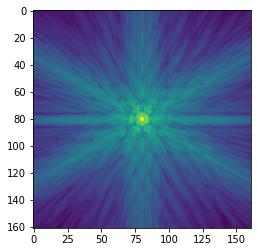

In [3]:
plt.imshow(np.log10(data_F200W))

### Define Loss and Optimizer Functions

In [ ]:
# Loss function
loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

### Define MSE TF Functions

In [ ]:
#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)
#define mse in log
@tf.function
def mse_log(y_true_in, y_pred_in):
    return loss_fn(y_true=np.log10(y_true_in),y_pred=np.log10(y_pred_in))

### Define grid positions

In [4]:
def gridxy(nx=161,ny=161):
    xl = np.arange(nx,dtype=np.float32)
    yl = np.arange(ny,dtype=np.float32)
#    xl += 0.5
#    yl += 0.5
    x,y = np.meshgrid(xl,yl)
    xy = np.dstack((x,y))
    return xy

In [ ]:
def gridxyns(nx=161,ny=161):
    xl = np.arange(nx,dtype=np.float32)
    yl = np.arange(ny,dtype=np.float32)
    x,y = np.meshgrid(xl,yl)
    xy = np.dstack((x,y))
    return xy

In [ ]:
#define model
@tf.function
def mvn_one_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x,sig_y]
    #sigma_b = [sig_x_b,sig_y_b]

    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    #gmvn_b = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_b)

    return gmvn_a.prob(x)#+gmvn_b.prob(x)

def mvn_one(x, mu, sigma):
    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma)
    return gmvn_a.prob(x)

### Create a single Gaussian model to fit

In [ ]:
xy = gridxy()
gg = mvn_one(xy, [0.5*xy.shape[0], 0.5*xy.shape[1]], [5., 6.])

### Perform single Gaussian fitting test

In [ ]:
#sig x
sig_x  = tf.Variable(1.0, name='sig_x')                       # 
#sig y
sig_y  = tf.Variable(1.0, name='sig_y')


mu_x_const = 80.5
mu_y_const = 80.5


#define model
@tf.function
def mvn_one_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x,sig_y]
    #sigma_b = [sig_x_b,sig_y_b]

    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    #gmvn_b = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_b)

    return gmvn_a.prob(x)#+gmvn_b.prob(x)


loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    #return tf.losses.mean_squared_error(y_true,y_pred)
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


#start training
epochs = 10000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = mvn_one_fit(xy)
        loss = mse(pred, gg)
        #print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_x_a.numpy()} s_y_a:{sig_y_a.numpy()} s_x_b:{sig_x_b.numpy()} s_y_b:{sig_y_b.numpy()}")
        print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_x.numpy()} s_y_a:{sig_y.numpy()}")

        
    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = mvn_one_fit(xy)
        loss = mse(gg,pred)
        
    #compute gradients
    gradients = g.gradient(loss, [sig_x,sig_y])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[sig_x,sig_y]))

### Plot residuals

In [ ]:
mu = [mu_x_const,mu_y_const]
sigma_a = [sig_x,sig_y]
gmodel = mvn_one(xy,mu,sigma_a)
plt.imshow(gmodel-gg)
plt.colorbar()

In [ ]:
plt.imshow(np.log10(np.absolute(np.fft.fft2(gg))))

### Create two gaussian model to fit

In [ ]:
def mvn_two(x, mu, sigma_0, sigma_1):
    #sigma_0 = [sig_0_x,sig_0_y]
    #sigma_1 = [sig_1_x,sig_1_y]

    gmvn_0 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)
    return gmvn_0.prob(x) + gmvn_1.prob(x)

xy = gridxy()
gg_two = mvn_two(xy, [0.5*xy.shape[0], 0.5*xy.shape[1]], [1., 1.5], [8., 9.])

plt.imshow(np.log10(gg_two))

### Perform two Gaussian fit test

In [ ]:
#sig x
sig_0_x  = tf.Variable(1.0, name='sig_0_x')                       # 
sig_0_y  = tf.Variable(1.0, name='sig_0_y')
sig_1_x  = tf.Variable(10.0, name='sig_1_x')                       # 
sig_1_y  = tf.Variable(10.0, name='sig_1_y')


mu_x_const = 80.5
mu_y_const = 80.5


#define model
@tf.function
def mvn_one_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x,sig_y]
    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    return gmvn_a.prob(x)#+gmvn_b.prob(x)

#define model
@tf.function
def mvn_two_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_0 = [sig_0_x,sig_0_y]
    sigma_1 = [sig_1_x,sig_1_y]

    gmvn_0 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)

    return gmvn_0.prob(x)+gmvn_1.prob(x)


loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    #return tf.losses.mean_squared_error(y_true,y_pred)
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


#start training
epochs = 10000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = mvn_two_fit(xy)
        loss = mse(pred, gg_two)
        print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_0_x.numpy()} s_y_a:{sig_0_y.numpy()} s_x_b:{sig_1_x.numpy()} s_y_b:{sig_1_y.numpy()}")
        #print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_x.numpy()} s_y_a:{sig_y.numpy()}")

        
    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = mvn_two_fit(xy)
        loss = mse(gg_two,pred)
        
    #compute gradients
    gradients = g.gradient(loss, [sig_0_x,sig_0_y,sig_1_x,sig_1_y])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[sig_0_x,sig_0_y,sig_1_x,sig_1_y]))

### Plot residuals

In [ ]:
mu = [mu_x_const,mu_y_const]
sigma_0 = [sig_0_x,sig_0_y]
sigma_1 = [sig_1_x,sig_1_y]
gmodel = mvn_two(xy,mu,sigma_0,sigma_1)
plt.imshow(gmodel-gg_two)
plt.colorbar()

In [ ]:
plt.imshow(np.log10(np.absolute(np.fft.fft2(gg_two))))

### Create three gaussian model to fit

In [ ]:
def mvn_three(x, mu, sigma_0, sigma_1, sigma_2):
    gmvn_0 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)
    gmvn_2 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_2)
    return gmvn_0.prob(x) + gmvn_1.prob(x) + gmvn_2.prob(x)

xy = gridxy()
gg_three = mvn_three(xy, [0.5*xy.shape[0], 0.5*xy.shape[1]], [1., 1.5], [8., 9.], [20., 30.])
plt.imshow(np.log10(gg_three))

### Perform three gaussian test

In [ ]:
#sig x
sig_0_x  = tf.Variable(1.0, name='sig_0_x')                       # 
sig_0_y  = tf.Variable(1.0, name='sig_0_y')
sig_1_x  = tf.Variable(10.0, name='sig_1_x')                       # 
sig_1_y  = tf.Variable(10.0, name='sig_1_y')
sig_2_x  = tf.Variable(20.0, name='sig_2_x')                       # 
sig_2_y  = tf.Variable(20.0, name='sig_2_y')


mu_x_const = 80.5
mu_y_const = 80.5


#define model
@tf.function
def mvn_one_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x,sig_y]
    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    return gmvn_a.prob(x)#+gmvn_b.prob(x)

#define model
@tf.function
def mvn_two_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_0 = [sig_0_x,sig_0_y]
    sigma_1 = [sig_1_x,sig_1_y]

    gmvn_0 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)

    return gmvn_0.prob(x)+gmvn_1.prob(x)

#define model
@tf.function
def mvn_three_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_0 = [sig_0_x,sig_0_y]
    sigma_1 = [sig_1_x,sig_1_y]
    sigma_2 = [sig_2_x,sig_2_y]


    gmvn_0 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)
    gmvn_2 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_2)


    return gmvn_0.prob(x)+gmvn_1.prob(x)+gmvn_2.prob(x)


loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


#start training
epochs = 10000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = mvn_three_fit(xy)
        loss = mse(pred, gg_two)
#        print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_0_x.numpy()} s_y_a:{sig_0_y.numpy()} s_x_b:{sig_1_x.numpy()} s_y_b:{sig_1_y.numpy()}")
        print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_0_x.numpy()} s_y_a:{sig_0_y.numpy()} s_x_b:{sig_1_x.numpy()} s_y_b:{sig_1_y.numpy()}  s_2_x:{sig_2_x.numpy()} s_2_y:{sig_2_y.numpy()}")


    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = mvn_three_fit(xy)
        loss = mse(gg_two,pred)
        
    #compute gradients
    gradients = g.gradient(loss, [sig_0_x,sig_0_y,sig_1_x,sig_1_y,sig_2_x,sig_2_y])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[sig_0_x,sig_0_y,sig_1_x,sig_1_y,sig_2_x,sig_2_y]))

### Plot Residuals

In [ ]:
mu = [mu_x_const,mu_y_const]
sigma_0 = [sig_0_x,sig_0_y]
sigma_1 = [sig_1_x,sig_1_y]
sigma_2 = [sig_2_x,sig_2_y]
gmodel = mvn_three(xy,mu,sigma_0,sigma_1,sigma_2)
plt.imshow(gmodel-gg_three)
plt.colorbar()

### Perform three gaussian fit to PSF

In [ ]:
#sig x
a_0 = tf.Variable(1.0, name='a_0')
a_1 = tf.Variable(1.0, name='a_1')
a_2 = tf.Variable(1.0, name='a_2')


sig_0_x  = tf.Variable(1.0, name='sig_0_x')                       # 
sig_0_y  = tf.Variable(1.0, name='sig_0_y')
sig_1_x  = tf.Variable(10.0, name='sig_1_x')                       # 
sig_1_y  = tf.Variable(10.0, name='sig_1_y')
sig_2_x  = tf.Variable(20.0, name='sig_2_x')                       # 
sig_2_y  = tf.Variable(20.0, name='sig_2_y')


mu_x_const = 80.5
mu_y_const = 80.5


#define model
@tf.function
def mvn_one_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x,sig_y]
    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    return gmvn_a.prob(x)#+gmvn_b.prob(x)

#define model
@tf.function
def mvn_two_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_0 = [sig_0_x,sig_0_y]
    sigma_1 = [sig_1_x,sig_1_y]

    gmvn_0 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)

    return gmvn_0.prob(x)+gmvn_1.prob(x)

#define model
@tf.function
def mvn_three_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_0 = [sig_0_x,sig_0_y]
    sigma_1 = [sig_1_x,sig_1_y]
    sigma_2 = [sig_2_x,sig_2_y]


    gmvn_0 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)
    gmvn_2 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_2)


    return tf.math.abs(a_0)*gmvn_0.prob(x)+tf.math.abs(a_1)*gmvn_1.prob(x)+tf.math.abs(a_2)*gmvn_2.prob(x)


loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


#start training
epochs = 20000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = mvn_three_fit(xy)
        loss = mse(pred, data_F200W)
#        print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_0_x.numpy()} s_y_a:{sig_0_y.numpy()} s_x_b:{sig_1_x.numpy()} s_y_b:{sig_1_y.numpy()}")
        print(f"Epoch {epoch} | Loss {loss.numpy()} a_0:{a_0.numpy()} a_1:{a_1.numpy()} a_2:{a_2.numpy()}")
        print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_0_x.numpy()} s_y_a:{sig_0_y.numpy()} s_x_b:{sig_1_x.numpy()} s_y_b:{sig_1_y.numpy()}  s_2_x:{sig_2_x.numpy()} s_2_y:{sig_2_y.numpy()}")


    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = mvn_three_fit(xy)
        loss = mse(data_F200W,pred)
        
    #compute gradients
    gradients = g.gradient(loss, [a_0,a_1,a_2,sig_0_x,sig_0_y,sig_1_x,sig_1_y,sig_2_x,sig_2_y])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[a_0,a_1,a_2,sig_0_x,sig_0_y,sig_1_x,sig_1_y,sig_2_x,sig_2_y]))

### Plot residuals

In [ ]:
def mvn_three_amp(x, mu, a_0, a_1, a_2, sigma_0, sigma_1, sigma_2):
    gmvn_0 =tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 =tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)
    gmvn_2 =tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_2)
    return  np.fabs(a_0)*gmvn_0.prob(x) +  np.fabs(a_1)*gmvn_1.prob(x) +  np.fabs(a_2)*gmvn_2.prob(x)

mu = [mu_x_const,mu_y_const]
sigma_0 = [sig_0_x,sig_0_y]
sigma_1 = [sig_1_x,sig_1_y]
sigma_2 = [sig_2_x,sig_2_y]
gmodel = mvn_three_amp(xy,mu,a_0,a_1,a_2,sigma_0,sigma_1,sigma_2)
plt.imshow(np.log10(np.fabs(gmodel-data_F200W)))
plt.colorbar()

### Compute FFT of PSF

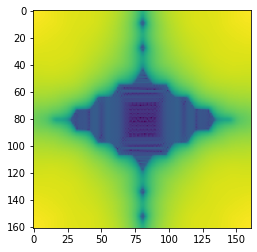

In [5]:
data_F200W_fft = np.absolute(np.fft.fft2(data_F200W))
plt.imshow(np.log10(data_F200W_fft))

### Perform three gaussian fit to PSF with Configuration and Fourier Space MSE loss

In [ ]:
#sig x
a_0 = tf.Variable(1.0, name='a_0')
a_1 = tf.Variable(1.0, name='a_1')
a_2 = tf.Variable(1.0, name='a_2')


sig_0_x  = tf.Variable(1.0, name='sig_0_x')                       # 
sig_0_y  = tf.Variable(1.0, name='sig_0_y')
sig_1_x  = tf.Variable(10.0, name='sig_1_x')                       # 
sig_1_y  = tf.Variable(10.0, name='sig_1_y')
sig_2_x  = tf.Variable(20.0, name='sig_2_x')                       # 
sig_2_y  = tf.Variable(20.0, name='sig_2_y')


mu_x_const = 80.5
mu_y_const = 80.5


#define model
@tf.function
def mvn_one_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x,sig_y]
    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    return gmvn_a.prob(x)#+gmvn_b.prob(x)

#define model
@tf.function
def mvn_two_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_0 = [sig_0_x,sig_0_y]
    sigma_1 = [sig_1_x,sig_1_y]

    gmvn_0 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)

    return gmvn_0.prob(x)+gmvn_1.prob(x)

#define model
@tf.function
def mvn_three_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_0 = [sig_0_x,sig_0_y]
    sigma_1 = [sig_1_x,sig_1_y]
    sigma_2 = [sig_2_x,sig_2_y]


    gmvn_0 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)
    gmvn_2 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_2)


    return tf.math.abs(a_0)*gmvn_0.prob(x)+tf.math.abs(a_1)*gmvn_1.prob(x)+tf.math.abs(a_2)*gmvn_2.prob(x)


loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


#start training
epochs = 20000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = mvn_three_fit(xy)
        pred_fft = np.absolute(np.fft.fft2(pred))
        loss = mse(pred, data_F200W) + mse(pred_fft, data_F200W_fft)
#        print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_0_x.numpy()} s_y_a:{sig_0_y.numpy()} s_x_b:{sig_1_x.numpy()} s_y_b:{sig_1_y.numpy()}")
        print(f"Epoch {epoch} | Loss {loss.numpy()} a_0:{a_0.numpy()} a_1:{a_1.numpy()} a_2:{a_2.numpy()}")
        print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_0_x.numpy()} s_y_a:{sig_0_y.numpy()} s_x_b:{sig_1_x.numpy()} s_y_b:{sig_1_y.numpy()}  s_2_x:{sig_2_x.numpy()} s_2_y:{sig_2_y.numpy()}")


    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = mvn_three_fit(xy)
        pred_fft = np.absolute(np.fft.fft2(pred))
        loss = mse(pred, data_F200W) + mse(pred_fft, data_F200W_fft)

        
    #compute gradients
    gradients = g.gradient(loss, [a_0,a_1,a_2,sig_0_x,sig_0_y,sig_1_x,sig_1_y,sig_2_x,sig_2_y])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[a_0,a_1,a_2,sig_0_x,sig_0_y,sig_1_x,sig_1_y,sig_2_x,sig_2_y]))

### Plot residuals

In [ ]:
def mvn_three_amp(x, mu, a_0, a_1, a_2, sigma_0, sigma_1, sigma_2):
    gmvn_0 =tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 =tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)
    gmvn_2 =tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_2)
    return  np.fabs(a_0)*gmvn_0.prob(x) +  np.fabs(a_1)*gmvn_1.prob(x) +  np.fabs(a_2)*gmvn_2.prob(x)

mu = [mu_x_const,mu_y_const]
sigma_0 = [sig_0_x,sig_0_y]
sigma_1 = [sig_1_x,sig_1_y]
sigma_2 = [sig_2_x,sig_2_y]
gmodel = mvn_three_amp(xy,mu,a_0,a_1,a_2,sigma_0,sigma_1,sigma_2)
plt.imshow(np.log10(np.fabs(gmodel-data_F200W)))
plt.colorbar()

In [ ]:
plt.imshow(np.log10(gmodel))

### Test the tukey function

In [ ]:
#initialize xy grid
xy = gridxy()
xyns = gridxyns()

t_a = tf.Variable(0.2)

def tukey_trans(fx,a,lam):
#    return 0.5*(1-np.cos((np.pi*fx/(a*lam) - np.pi/a) ))
    return 0.5*(1-tf.math.cos((np.pi*fx/(a*lam) - np.pi/a) ))
    

    
def tukey_calc(x,ta):
    # Def 4.3 of 1901.04365

    
    lam = 82.#mu_x_const
    ta = t_a
    al = (1.0-t_a)*lam
    fx = np.fabs(x)
    y = np.zeros_like(x)
         
    #inner bump
    xs = x[fx<al]
    y[fx<al] = 1.
        
    #transition
    xl = x[(fx>=al)&(fx<=lam)]
    y[(fx>=al)&(fx<=lam)] = tukey_trans(fx[(fx>=al)&(fx<=lam)],ta,lam)
    return y


#tukey filter
#@tf.function
def tukey(x):
    nx = x.shape[0]
    ny = x.shape[0]
    ta = t_a
    nx = x.shape[0]
    ny = x.shape[0]
    ta = t_a
    xx = x#.numpy()
    #return tukey_calc((xx[:,:,0]**2 + xx[:,:,1]**2)**0.5,ta) + tukey_calc(((xx[:,:,0]-nx)**2 + xx[:,:,1]**2)**0.5,ta) + tukey_calc((xx[:,:,0]**2 + (xx[:,:,1]-ny)**2)**0.5,ta) + tukey_calc(((xx[:,:,0]-nx)**2 + (xx[:,:,1]-ny)**2)**0.5,ta)
    x0 = tf.math.sqrt(tf.math.pow(x[:,:,0],2) + tf.math.pow(x[:,:,1],2) ) 
    x1 = tf.math.sqrt(tf.math.pow(x[:,:,0]-nx,2) + tf.math.pow(x[:,:,1],2) ) 
    x2 = tf.math.sqrt(tf.math.pow(x[:,:,0]   ,2) + tf.math.pow(x[:,:,1]-ny,2) ) 
    x3 = tf.math.sqrt(tf.math.pow(x[:,:,0]-nx,2) + tf.math.pow(x[:,:,1]-ny,2) ) 

    return tukey_calc(x0,ta) + tukey_calc(x1,ta) + tukey_calc(x2,ta) + tukey_calc(x3,ta)


In [ ]:
t = tukey(xy)
plt.imshow(np.log10(t))

In [ ]:

gmodel_new = np.absolute((np.fft.irfft2(np.fft.rfft2(gmodel)*t[:,0:81])))
plt.imshow(np.log10(gmodel_new))
#plt.imshow(np.log10(gmodel-gmodel_new))




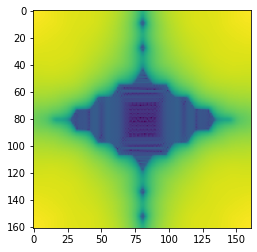

In [5]:
data_F200W_fft = np.absolute(np.fft.fft2(data_F200W))
plt.imshow(np.log10(data_F200W_fft))

In [219]:
#def gridxy(nx=161,ny=161):
#    xl = np.arange(nx,dtype=np.float32)
#    yl = np.arange(ny,dtype=np.float32)
#    x,y = np.meshgrid(xl,yl)
#    xy = np.dstack((x,y))
#    return xy
xtest = gridxy()
#print(xtest)
print(xtest[161-1-80,161-1-80])

[80. 80.]


### Perform three gaussian fit to PSF with Configuration and Fourier Space MSE loss with Tukey FFT Filter

In [262]:
#initialize xy grid
xy = gridxy()
#xyns = gridxyns()
#xy = gridxy()

#Epoch 9000 | Loss 0.00047437906325887885 a_0:1.2768806219100952 a_1:0.8796517848968506 a_2:0.20107834041118622
#Epoch 9000 | Loss 0.00047437906325887885 s_x_a:0.8591179251670837 s_y_a:0.8574327826499939 s_x_b:6.971626281738281 s_y_b:6.38992166519165  s_2_x:20.330425262451172 s_2_y:20.212379455566406
#Epoch 9000 | Loss 0.00047437906325887885 t_a:0.1430569887161255

#sig x
a_0 = tf.Variable(1.2768806219100952, name='a_0')
a_1 = tf.Variable(0.8796517848968506, name='a_1')
a_2 = tf.Variable(0.20107834041118622, name='a_2')


sig_0_x  = tf.Variable(0.8591179251670837, name='sig_0_x')                       # 
sig_0_y  = tf.Variable(0.8574327826499939, name='sig_0_y')
sig_1_x  = tf.Variable(6.971626281738281, name='sig_1_x')                       # 
sig_1_y  = tf.Variable(6.38992166519165, name='sig_1_y')
sig_2_x  = tf.Variable(20.330425262451172, name='sig_2_x')                       # 
sig_2_y  = tf.Variable(20.212379455566406, name='sig_2_y')

t_a = tf.Variable(0.1430569887161255, name='t_a')


scale = 1.0e-6


mu_x_const = 80.0
mu_y_const = 80.0


#define model
@tf.function
def mvn_one_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x,sig_y]
    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    return gmvn_a.prob(x)#+gmvn_b.prob(x)

#define model
@tf.function
def mvn_two_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_0 = [sig_0_x,sig_0_y]
    sigma_1 = [sig_1_x,sig_1_y]

    gmvn_0 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)

    return gmvn_0.prob(x)+gmvn_1.prob(x)

#define model
@tf.function
def mvn_three_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_0 = [sig_0_x,sig_0_y]
    sigma_1 = [sig_1_x,sig_1_y]
    sigma_2 = [sig_2_x,sig_2_y]


    gmvn_0 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)
    gmvn_2 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_2)


    return tf.math.abs(a_0)*gmvn_0.prob(x)+tf.math.abs(a_1)*gmvn_1.prob(x)+tf.math.abs(a_2)*gmvn_2.prob(x)



def tukey_trans(fx,a,lam):
#    return 0.5*(1-np.cos((np.pi*fx/(a*lam) - np.pi/a) ))
    return 0.5*(1-tf.math.cos((np.pi*fx/(a*lam) - np.pi/a) ))
    

    
def tukey_calc(x,ta):
    # Def 4.3 of 1901.04365

    
    lam = mu_x_const-1.
    #ta = t_a
    al = (1.0-t_a)*lam
    #fx = np.fabs(x)
    #y = np.zeros_like(x)
    fx = tf.abs(x)
    y = tf.zeros(x.shape)
    
    #inner bump
    #xs = x[fx<al]
    one_index = tf.math.less(fx,al)
    y = tf.where(one_index,tf.ones(x.shape),tf.zeros(x.shape))
    #return y
    #y = tf.ones(x.shape)

    and_index = tf.math.less_equal(fx,lam)&tf.math.greater_equal(fx,al)
    y_trans = tf.where(and_index,tukey_trans(fx,ta,lam),y)
    #y_trans = y
    
    #transition
    #xl = x[(fx>=al)&(fx<=lam)]
    #y[(fx>=al)&(fx<=lam)] = tukey_trans(fx[(fx>=al)&(fx<=lam)],ta,lam)
    return y_trans


#tukey filter
@tf.function
def tukey(x):
    nx = x.shape[0]
    ny = x.shape[1]
    ta = t_a
    xx = x#.numpy()
    #return tukey_calc((xx[:,:,0]**2 + xx[:,:,1]**2)**0.5,ta) + tukey_calc(((xx[:,:,0]-nx)**2 + xx[:,:,1]**2)**0.5,ta) + tukey_calc((xx[:,:,0]**2 + (xx[:,:,1]-ny)**2)**0.5,ta) + tukey_calc(((xx[:,:,0]-nx)**2 + (xx[:,:,1]-ny)**2)**0.5,ta)
    x0 = tf.math.sqrt(tf.math.pow(x[:,:,0],2) + tf.math.pow(x[:,:,1],2) ) 
    x1 = tf.math.sqrt(tf.math.pow(nx-1-x[:,:,0],2) + tf.math.pow(x[:,:,1],2) ) 
    x2 = tf.math.sqrt(tf.math.pow(x[:,:,0]   ,2) + tf.math.pow(ny-1-x[:,:,1],2) ) 
    x3 = tf.math.sqrt(tf.math.pow(nx-1-x[:,:,0],2) + tf.math.pow(ny-1-x[:,:,1],2) ) 

    t_real = tukey_calc(x0,ta) + tukey_calc(x1,ta) + tukey_calc(x2,ta) + tukey_calc(x3,ta)
    
    #return tf.complex(t_real, tf.zeros(x.shape[:1]))
    return t_real/tf.math.reduce_max(t_real)


loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)



#flag_train = False
flag_train = True
if(flag_train):
    #start training
    epochs = 10000
    display_step = 1000
    for epoch in range(epochs):
    
        #monitor training / display steps
        if((epoch%display_step)==0):
            pred = mvn_three_fit(xy)
            #pred /= tf.math.reduce_sum(pred)
            #pred_fft = tf.math.abs(tf.signal.fft2d(tf.dtypes.complex(pred,tf.zeros_like(pred))))
            #pred_fft = tf.signal.fft2d(tf.dtypes.complex(pred,tf.zeros_like(pred)))
            tukey_filter = tukey(xy)
            #pred_fft_comp = tf.complex(pred_fft,
            #pred_fft *= tukey_filter
            #pred = tf.math.abs(tf.signal.ifft2d(tf.complex(pred_fft,tf.zeros_like(pred_fft))))
            pred_fft = tf.signal.fft2d(tf.dtypes.complex(pred,tf.zeros_like(pred)))
            pred_fft_tuk = tf.complex(tf.math.real(pred_fft)*tukey_filter,tf.math.imag(pred_fft)*tukey_filter)
            pred = tf.math.abs(tf.signal.ifft2d(tf.complex(tf.math.real(pred_fft)*tukey_filter,tf.math.imag(pred_fft)*tukey_filter)))
            pred *= tf.math.reduce_sum(tf.cast(data_F200W[60:100,60:100],tf.float32))/tf.math.reduce_sum(pred[60:100,60:100])
            pred_fft = tf.math.abs(tf.signal.fft2d(tf.dtypes.complex(pred,tf.zeros_like(pred))))
            loss = mse(pred, data_F200W) + scale*mse(tf.math.log(pred_fft), tf.math.log(data_F200W_fft))
#            loss = mse(pred, data_F200W)

            #loss = tf.cast(0.0,tf.float64)

    #        print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_0_x.numpy()} s_y_a:{sig_0_y.numpy()} s_x_b:{sig_1_x.numpy()} s_y_b:{sig_1_y.numpy()}")
            print(f"Epoch {epoch} | Loss {loss.numpy()} a_0:{a_0.numpy()} a_1:{a_1.numpy()} a_2:{a_2.numpy()}")
            print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_0_x.numpy()} s_y_a:{sig_0_y.numpy()} s_x_b:{sig_1_x.numpy()} s_y_b:{sig_1_y.numpy()}  s_2_x:{sig_2_x.numpy()} s_2_y:{sig_2_y.numpy()}")
            print(f"Epoch {epoch} | Loss {loss.numpy()} t_a:{t_a.numpy()}")
            print(f"Epoch {epoch} | Loss {loss.numpy()} sum model:{(tf.math.reduce_sum(pred)).numpy()} sum:{(tf.math.reduce_sum(data_F200W)).numpy()}")


        #begin GradientTape and optimize
        with tf.GradientTape() as g:
            pred = mvn_three_fit(xy)
            #pred /= tf.math.reduce_sum(pred)
            #pred_fft = tf.math.abs(tf.signal.fft2d(tf.dtypes.complex(pred,tf.zeros_like(pred))))
            #pred_fft = tf.signal.fft2d(tf.dtypes.complex(pred,tf.zeros_like(pred)))
            tukey_filter = tukey(xy)
            #pred_fft_comp = tf.complex(pred_fft,
            #pred_fft *= tukey_filter
            #pred = tf.math.abs(tf.signal.ifft2d(tf.complex(pred_fft,tf.zeros_like(pred_fft))))
            pred_fft = tf.signal.fft2d(tf.dtypes.complex(pred,tf.zeros_like(pred)))
            pred_fft_tuk = tf.complex(tf.math.real(pred_fft)*tukey_filter,tf.math.imag(pred_fft)*tukey_filter)
            pred = tf.math.abs(tf.signal.ifft2d(tf.complex(tf.math.real(pred_fft)*tukey_filter,tf.math.imag(pred_fft)*tukey_filter)))
            pred *= tf.math.reduce_sum(tf.cast(data_F200W[60:100,60:100],tf.float32))/tf.math.reduce_sum(pred[60:100,60:100])
    
    #        loss = mse(pred, data_F200W) + mse(pred_fft, data_F200W_fft)
            #loss = mse(pred, data_F200W) + scale*mse(tf.math.log(tf.abs(pred_fft)), tf.math.log(data_F200W_fft))
            #loss = mse(pred, data_F200W) + scale*mse(tf.math.log(tf.abs(pred_fft_tuk)), tf.math.log(tf.abs(data_F200W_fft)))
            pred_fft = tf.math.abs(tf.signal.fft2d(tf.dtypes.complex(pred,tf.zeros_like(pred))))
            loss = mse(pred, data_F200W) + scale*mse(tf.math.log(pred_fft), tf.math.log(data_F200W_fft))



        #compute gradients
        gradients = g.gradient(loss, [a_0,a_1,a_2,sig_0_x,sig_0_y,sig_1_x,sig_1_y,sig_2_x,sig_2_y,t_a])

        #update parameters
        optimizer.apply_gradients(zip(gradients,[a_0,a_1,a_2,sig_0_x,sig_0_y,sig_1_x,sig_1_y,sig_2_x,sig_2_y,t_a]))
    
    loss = mse(pred, data_F200W) + scale*mse(tf.math.log(pred_fft), tf.math.log(data_F200W_fft))
    epoch = epochs
    print(f"Epoch {epoch} | Loss {loss.numpy()} a_0:{a_0.numpy()} a_1:{a_1.numpy()} a_2:{a_2.numpy()}")
    print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_0_x.numpy()} s_y_a:{sig_0_y.numpy()} s_x_b:{sig_1_x.numpy()} s_y_b:{sig_1_y.numpy()}  s_2_x:{sig_2_x.numpy()} s_2_y:{sig_2_y.numpy()}")
    print(f"Epoch {epoch} | Loss {loss.numpy()} t_a:{t_a.numpy()}")
    print(f"Epoch {epoch} | Loss {loss.numpy()} sum model:{(tf.math.reduce_sum(pred)).numpy()} sum:{(tf.math.reduce_sum(data_F200W)).numpy()}")


Epoch 0 | Loss 0.00047437906325887885 a_0:1.2768806219100952 a_1:0.8796517848968506 a_2:0.20107834041118622
Epoch 0 | Loss 0.00047437906325887885 s_x_a:0.8591179251670837 s_y_a:0.8574327826499939 s_x_b:6.971626281738281 s_y_b:6.38992166519165  s_2_x:20.330425262451172 s_2_y:20.212379455566406
Epoch 0 | Loss 0.00047437906325887885 t_a:0.1430569887161255
Epoch 0 | Loss 0.00047437906325887885 sum model:0.9827734231948853 sum:0.9840865672496912
Epoch 1000 | Loss 0.0004703060648120008 a_0:1.275982141494751 a_1:0.8715571761131287 a_2:0.21332649886608124
Epoch 1000 | Loss 0.0004703060648120008 s_x_a:0.8585005402565002 s_y_a:0.8574015498161316 s_x_b:6.970437049865723 s_y_b:6.40130615234375  s_2_x:20.31241798400879 s_2_y:20.20540428161621
Epoch 1000 | Loss 0.0004703060648120008 t_a:0.14333289861679077
Epoch 1000 | Loss 0.0004703060648120008 sum model:0.9855566620826721 sum:0.9840865672496912
Epoch 2000 | Loss 0.000468915428931592 a_0:1.2788530588150024 a_1:0.8600589036941528 a_2:0.2312549650669

1.0


__main__:1: RuntimeWarning: divide by zero encountered in log10


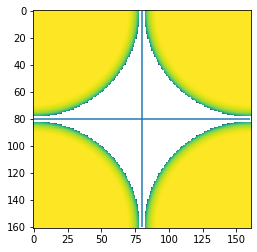

In [278]:
plt.imshow(np.log10(tukey_filter))
print(np.max(tukey_filter))
plt.hlines(80.,0,160)
plt.vlines(80.,0,160)

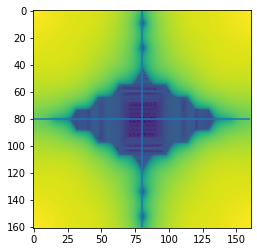

In [277]:
#plt.imshow(tf.math.log(tf.math.abs(pred_fft_tuk)))
#plt.imshow(tf.math.log(tf.math.abs(pred_fft)))
#plt.imshow(tf.math.log(tf.math.abs(tukey_filter)))
plt.imshow(tf.math.log(tf.math.abs(data_F200W_fft)))
plt.hlines(80.,0,160)
plt.vlines(80.,0,160)

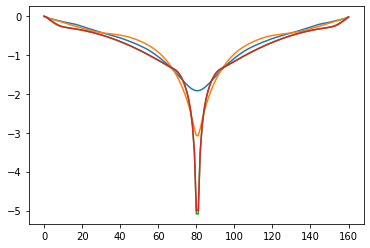

In [263]:
plt.plot(np.log10(np.absolute(data_F200W_fft[:,0])))
#plt.plot(np.log10(np.absolute(pred_fft_tuk[:,0])))
plt.plot(np.log10(np.absolute(data_F200W_fft[0,:])))
#plt.plot(np.log10(np.absolute(pred_fft_tuk[0,:]/10)))
#plt.plot(np.log10(np.absolute(tukey_filter[0,:])))
plt.plot(np.log10(np.absolute(pred_fft[:,0])))
plt.plot(np.log10(np.absolute(pred_fft[0,:])))


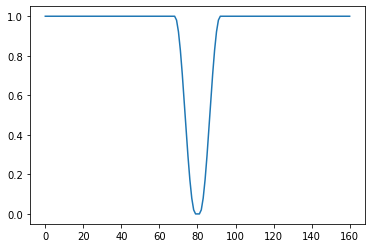

In [264]:
plt.plot(tukey_filter[0,:])

0.9966221


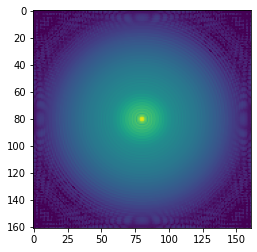

In [265]:
plt.imshow(np.log10(pred),vmin=-8.1,vmax=-0.8)
print(np.sum(pred))

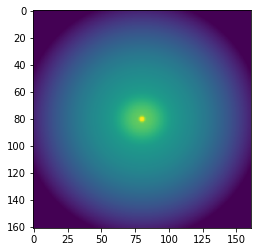

In [266]:
plt.imshow(np.log10(mvn_three_fit(xy)),vmin=-8.1,vmax=-0.8)


-8.093935829214276 -0.8415539081671065


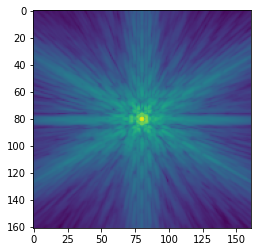

In [267]:
plt.imshow(np.log10(data_F200W),vmin=-8.1,vmax=-0.8)
print(np.min(np.log10(data_F200W)),np.max(np.log10(data_F200W)))

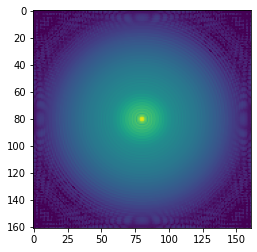

In [268]:
#pred = mvn_three_fit(xy)
#pred_fft = tf.signal.fft2d(tf.dtypes.complex(pred,tf.zeros_like(pred)))
#pred = tf.math.abs(tf.signal.ifft2d(tf.complex(tf.math.real(pred_fft)*tf.ones_like(pred),tf.math.imag(pred_fft)*tf.ones_like(pred))))
#pred = tf.math.abs(tf.signal.ifft2d(tf.complex(tf.math.real(pred_fft)*tf.ones_like(pred),tf.math.imag(pred_fft)*tf.ones_like(pred))))
#pred = tf.math.abs(tf.signal.ifft2d(tf.complex(tf.math.real(pred_fft)*tukey_filter,tf.math.imag(pred_fft)*tukey_filter)))

plt.imshow(np.log10(pred),vmin=-8.1,vmax=-0.8)

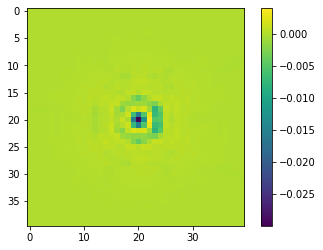

In [269]:
plt.imshow((pred[60:100,60:100]-data_F200W[60:100,60:100]))
plt.colorbar()

-6.088615036148339 -0.8415539081671065


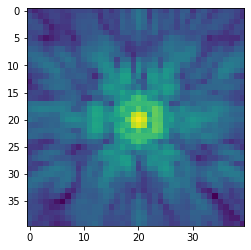

In [270]:
plt.imshow(np.log10(data_F200W[60:100,60:100]),vmin=-6.1,vmax=-0.8)
print(np.min(np.log10(data_F200W[60:100,60:100])),np.max(np.log10(data_F200W[60:100,60:100])))

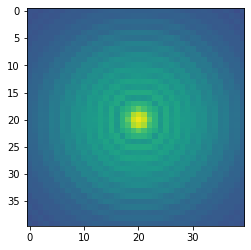

In [271]:
plt.imshow(np.log10(pred[60:100,60:100]),vmin=-6.1,vmax=-0.8)

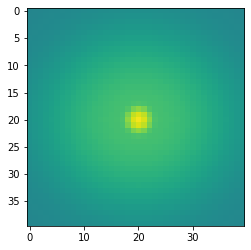

In [282]:
pmvn = mvn_three_fit(xy)
plt.imshow(np.log10(pmvn[60:100,60:100]/np.sum(pmvn)),vmin=-8.1,vmax=-0.8)


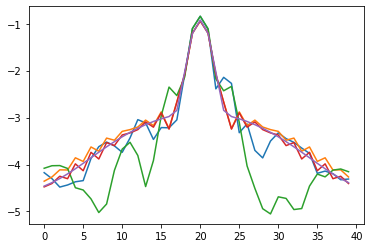

In [281]:
plt.plot(np.log10(data_F200W[80,60:100]))
plt.plot(np.log10(pred[80,60:100]))
plt.plot(np.log10(data_F200W[60:100,80]))
plt.plot(np.log10(pred[60:100,80]))
plt.plot(np.log10(pmvn[60:100,80]/np.sum(pmvn)))


### Test single gaussian fitting

In [ ]:

v = train_model(xy,gg,fit_single_gaussian)

In [ ]:
#x mean
mu_x  = tf.Variable(80.0, name='x_mean')                       # 
#y mean
mu_y  = tf.Variable(80.0, name='y_mean') 
#x sigma
sig_x = tf.Variable(0.75, name='x_sig')
#y sigma
sig_y = tf.Variable(0.75, name='y_sig')

#define model
@tf.function
def mvn_fit(x):
    mu = [mu_x,mu_y]
    sigma = [sig_x,sig_y]
    gmvn = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma)
    return gmvn.prob(x)

loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    #return tf.losses.mean_squared_error(y_true,y_pred)
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)



In [ ]:
def mvn_set(x,mu,sigma):
    print(type(mu))
    print(type(sigma))
    gmvn = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma)
    return gmvn.prob(x)

In [ ]:
nx = 161
ny = 161
xl = np.arange(nx,dtype=np.float32)
yl = np.arange(ny,dtype=np.float32)
xl += 0.5
yl += 0.5
x,y = np.meshgrid(xl,yl)
#x += 0.5
#y += 0.5
xy = np.dstack((x,y))
print(xy.shape)
print(xl[80])


In [ ]:
mu = np.array([0.5*nx,0.5*ny])
Sigma = np.array([10.,8.])
gg = np.reshape(mvn_set(xy,mu,Sigma),(nx,ny))
print(type(gg[0,0]))

In [ ]:
plt.imshow(gg)

In [ ]:
print(f" Loss {loss.numpy()}, mu_x: {mu_x.numpy()} mu_y:{mu_y.numpy()} s_x:{sig_x.numpy()} s_y:{sig_y.numpy()}")


In [ ]:
plt.imshow(gg-pred)
plt.colorbar()

In [ ]:
#Try two gaussians

In [ ]:
mu = np.array([0.5*nx,0.5*ny])
Sigma_a = np.array([2.,2.5])
Sigma_b = np.array([10.,15.])
mu = np.array([0.5*nx,0.5*ny])
gg = np.reshape(mvn_set(xy,mu,Sigma_a)+mvn_set(xy,mu,Sigma_b),(nx,ny)) 
print(type(gg[0,0]))

In [ ]:
plt.plot(gg[80,:])
plt.yscale('log')

In [ ]:
#sig x a
sig_x_a  = tf.Variable(1.0, name='sig_x_a')                       # 
#sig y a
sig_y_a  = tf.Variable(1.0, name='sig_y_a')

#sig x b
sig_x_b  = tf.Variable(10.0, name='sig_x_b')                       # 
#sig y b
sig_y_b  = tf.Variable(10.0, name='sig_y_b')

mu_x_const = 80.5
mu_y_const = 80.5


#define model
@tf.function
def mvn_two_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x_a,sig_y_a]
    sigma_b = [sig_x_b,sig_y_b]

    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    gmvn_b = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_b)

    return gmvn_a.prob(x)+gmvn_b.prob(x)

loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    #return tf.losses.mean_squared_error(y_true,y_pred)
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#start training
epochs = 20000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = mvn_two_fit(xy)
        loss = mse(pred, gg)
        print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_x_a.numpy()} s_y_a:{sig_y_a.numpy()} s_x_b:{sig_x_b.numpy()} s_y_b:{sig_y_b.numpy()}")
        
    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = mvn_two_fit(xy)
        loss = mse(gg,pred)
        
    #compute gradients
    gradients = g.gradient(loss, [sig_x_a,sig_y_a,sig_x_b,sig_y_b])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[sig_x_a,sig_y_a,sig_x_b,sig_y_b]))

In [ ]:
#start training
epochs = 20000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = mvn_two_fit(xy)
        loss = mse(pred, gg)
        print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_x_a.numpy()} s_y_a:{sig_y_a.numpy()} s_x_b:{sig_x_b.numpy()} s_y_b:{sig_y_b.numpy()}")
        
    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = mvn_two_fit(xy)
        loss = mse(gg,pred)
        
    #compute gradients
    gradients = g.gradient(loss, [sig_x_a,sig_y_a,sig_x_b,sig_y_b])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[sig_x_a,sig_y_a,sig_x_b,sig_y_b]))

In [ ]:
plt.imshow(gg-pred)
plt.colorbar()

In [ ]:
plt.imshow(np.log10(gg))

In [ ]:
plt.imshow(np.log10(pred))

In [ ]:
!python3 -m pip list | grep webbpsf

In [ ]:
!python3 -m pip install webbpsf

In [ ]:
!python3 -m pip install astropy

In [ ]:
import os
!export WEBBPSF_PATH=/data/groups/comp-astro/jades/webbpsf-data 
os.environ["WEBBPSF_PATH"] = "/data/groups/comp-astro/jades/webbpsf-data"

In [ ]:
!echo $WEBBPSF_PATH

In [ ]:
import webbpsf

In [ ]:
nc = webbpsf.NIRCam()
nc.filter = 'F200W'
psf = nc.calc_psf(detector_oversample=1,fft_oversample=4)
plt.imshow(psf[0].data)
webbpsf.display_psf(psf)

In [ ]:
nc = webbpsf.NIRCam()
nc.filter = 'F200W'
psf = nc.calc_psf(detector_oversample=1,fft_oversample=4)
plt.imshow(psf[0].data)
webbpsf.display_psf(psf)

In [ ]:
psf_data = psf[0].data

In [ ]:
print(psf_data.shape)

In [ ]:
#amp
amp = tf.Variable(0.5, name='amp')

#sig x a
sig_x_a  = tf.Variable(1.0, name='sig_x_a')                       # 
#sig y a
sig_y_a  = tf.Variable(1.0, name='sig_y_a')

#sig x b
sig_x_b  = tf.Variable(10.0, name='sig_x_b')                       # 
#sig y b
sig_y_b  = tf.Variable(10.0, name='sig_y_b')

mu_x_const = 80.5
mu_y_const = 80.5


#define model
@tf.function
def mvn_two_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x_a,sig_y_a]
    sigma_b = [sig_x_b,sig_y_b]

    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    gmvn_b = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_b)

    return amp*gmvn_a.prob(x)+(1.-amp)*gmvn_b.prob(x)

loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    #return tf.losses.mean_squared_error(y_true,y_pred)
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
#start training
epochs = 20000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = mvn_two_fit(xy)
        loss = mse(psf_data,pred)
        print(f"Epoch {epoch} | Loss {loss.numpy()} amp:{amp.numpy()} s_x_a:{sig_x_a.numpy()} s_y_a:{sig_y_a.numpy()} s_x_b:{sig_x_b.numpy()} s_y_b:{sig_y_b.numpy()}")
        
    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = mvn_two_fit(xy)
        loss = mse(psf_data,pred)
        
    #compute gradients
    gradients = g.gradient(loss, [amp,sig_x_a,sig_y_a,sig_x_b,sig_y_b])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[amp,sig_x_a,sig_y_a,sig_x_b,sig_y_b]))

In [ ]:
plt.imshow(np.log10(psf_data))
print(np.min(np.log10(psf_data)),np.max(np.log10(psf_data)))
plt.colorbar()

In [ ]:
plt.imshow(np.log10(pred))
plt.colorbar()

In [ ]:
plt.plot(np.log10(psf_data[80,:]))
plt.plot(np.log10(pred[80,:]))
plt.ylim([-10,0])

In [ ]:
plt.plot(np.log10(psf_data[:,80]))
plt.plot(np.log10(pred[:,80]))
plt.ylim([-10,0])

In [ ]:
#amp
amp_a = tf.Variable(0.5, name='amp_a')

#amp
amp_b = tf.Variable(0.25, name='amp_b')

#amp
amp_c = tf.Variable(0.05, name='amp_c')

#sig x a
sig_x_a  = tf.Variable(1.0, name='sig_x_a')                       # 
#sig y a
sig_y_a  = tf.Variable(1.0, name='sig_y_a')

#sig x b
sig_x_b  = tf.Variable(10.0, name='sig_x_b')                       # 
#sig y b
sig_y_b  = tf.Variable(10.0, name='sig_y_b')

#sig x c
sig_x_c  = tf.Variable(20.0, name='sig_x_c')                       # 
#sig y c
sig_y_c  = tf.Variable(20.0, name='sig_y_c')

mu_x_const = 80.5
mu_y_const = 80.5


#define model
@tf.function
def mvn_three_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x_a,sig_y_a]
    sigma_b = [sig_x_b,sig_y_b]
    sigma_c = [sig_x_c,sig_y_c]

    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    gmvn_b = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_b)
    gmvn_c = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_c)

    return tf.math.abs(amp_a)*gmvn_a.prob(x)+tf.math.abs(amp_b)*gmvn_b.prob(x)+tf.math.abs(amp_c)*gmvn_c.prob(x)

loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    #return tf.losses.mean_squared_error(y_true,y_pred)
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

@tf.function
def mse_log(y_true_in, y_pred_in):
    return loss_fn(y_true=tf.math.log(y_true_in),y_pred=tf.math.log(y_pred_in))

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
#start training
klam = 1.0e6
epochs = 20000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = mvn_three_fit(xy)
#        loss = mse(psf_data,pred)
#        loss = mse_log(psf_data,pred)
        loss = mse_log(psf_data,pred)+klam*mse(psf_data,pred)

        print(f"Epoch {epoch} | Loss {loss.numpy()} amp_a:{amp_a.numpy()} amp_b:{amp_b.numpy()} amp_c:{amp_c.numpy()} s_x_a:{sig_x_a.numpy()} s_y_a:{sig_y_a.numpy()} s_x_b:{sig_x_b.numpy()} s_y_b:{sig_y_b.numpy()} s_x_c:{sig_x_c.numpy()} s_y_c:{sig_y_c.numpy()}")
        
    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = mvn_three_fit(xy)
#        loss = mse(psf_data,pred)
#        loss = mse_log(psf_data,pred)
        loss = mse_log(psf_data,pred)+klam*mse(psf_data,pred)
        
    #compute gradients
    gradients = g.gradient(loss, [amp_a,amp_b,amp_c,sig_x_a,sig_y_a,sig_x_b,sig_y_b,sig_x_c,sig_y_c])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[amp_a,amp_b,amp_c,sig_x_a,sig_y_a,sig_x_b,sig_y_b,sig_x_c,sig_y_c]))

In [ ]:
plt.plot(np.log10(psf_data[80,:]))
plt.plot(np.log10(pred[80,:].numpy()))
plt.ylim([-10,0])

In [ ]:
plt.imshow(np.log10(pred)-np.log10(psf_data))
plt.colorbar()

In [ ]:
plt.imshow(pred-psf_data,vmin=-0.009,vmax=0.009,cmap='bwr')
plt.colorbar()

In [ ]:
def tukey(x,lam,a):
    # Def 4.3 of 1901.04365

    def tukey_trans(fx,a,lam):
        return 0.5*(1-np.cos((np.pi*fx/(a*lam) - np.pi/a) ))
    
    al = (1.0-a)*lam
    fx = np.fabs(x)
    if(isinstance(x,float)):
        y = 0.0
        if(fx<al):
            y = 1.0
        elif(fx<=lam):
            y = tukey_trans(fx,a,lam)
    else:
        y = np.zeros_like(x)
         
        #inner bump
        xs = x[fx<al]
        y[fx<al] = 1.
        
        #transition
        xl = x[(fx>=al)&(fx<=lam)]
        y[(fx>=al)&(fx<=lam)] = tukey_trans(fx[(fx>=al)&(fx<=lam)],a,lam)
    return y

In [ ]:
#amp
amp_a = tf.Variable(0.5, name='amp_a')

#amp
amp_b = tf.Variable(0.25, name='amp_b')

#amp
amp_c = tf.Variable(0.05, name='amp_c')

#sig x a
sig_x_a  = tf.Variable(1.0, name='sig_x_a')                       # 
#sig y a
sig_y_a  = tf.Variable(1.0, name='sig_y_a')

#sig x b
sig_x_b  = tf.Variable(10.0, name='sig_x_b')                       # 
#sig y b
sig_y_b  = tf.Variable(10.0, name='sig_y_b')

#sig x c
sig_x_c  = tf.Variable(20.0, name='sig_x_c')                       # 
#sig y c
sig_y_c  = tf.Variable(20.0, name='sig_y_c')

mu_x_const = 80.5
mu_y_const = 80.5


#define model
@tf.function
def mvn_three_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x_a,sig_y_a]
    sigma_b = [sig_x_b,sig_y_b]
    sigma_c = [sig_x_c,sig_y_c]

    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    gmvn_b = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_b)
    gmvn_c = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_c)

    return tf.math.abs(amp_a)*gmvn_a.prob(x)+tf.math.abs(amp_b)*gmvn_b.prob(x)+tf.math.abs(amp_c)*gmvn_c.prob(x)

loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    #return tf.losses.mean_squared_error(y_true,y_pred)
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

@tf.function
def mse_log(y_true_in, y_pred_in):
    return loss_fn(y_true=tf.math.log(y_true_in),y_pred=tf.math.log(y_pred_in))

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
#apply tukey bump function to 

In [ ]:
#define model
@tf.function
def model_function(x):
    
    #initial 3 gaussian approximation
    gapp = mvn_three_fit(x)
    
    #take fourier transform
    gapp_fft = tf.signal.fft2d(gapp)
    
    return gcomp
    
    

In [ ]:
#start training
klam = 1.0e6
epochs = 20000
display_step = 1000
for epoch in range(epochs):
    
    #monitor training / display steps
    if((epoch%display_step)==0):
        pred = model_function(xy)
        loss = mse(psf_data,pred)
#        loss = mse_log(psf_data,pred)
#        loss = mse_log(psf_data,pred)+klam*mse(psf_data,pred)

        print(f"Epoch {epoch} | Loss {loss.numpy()} amp_a:{amp_a.numpy()} s_x_a:{sig_x_a.numpy()} s_y_a:{sig_y_a.numpy()} s_x_b:{sig_x_b.numpy()} s_y_b:{sig_y_b.numpy()}")
        
    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = model_function(xy)
        loss = mse(psf_data,pred)
#        loss = mse_log(psf_data,pred)
#        loss = mse_log(psf_data,pred)+klam*mse(psf_data,pred)
        
    #compute gradients
    gradients = g.gradient(loss, [amp_a,sig_x_a,sig_y_a,sig_x_b,sig_y_b])
    
    #update parameters
    optimizer.apply_gradients(zip(gradients,[amp_a,sig_x_a,sig_y_a,sig_x_b,sig_y_b]))

In [ ]:
plt.imshow(np.log10(pred))

In [ ]:
plt.plot(np.log10(psf_data[80,:]))
plt.plot(np.log10(pred[80,:].numpy()))
plt.ylim([-10,0])

In [ ]:
pred_fft = tf.signal.fft2d(tf.cast(pred,dtype=tf.complex64))

In [ ]:
print((np.absolute(pred_fft.numpy()).shape))

In [ ]:
plt.imshow(tf.abs(pred_fft))

In [ ]:
pred_ifft = tf.signal.ifft2d(pred_fft)

In [ ]:
plt.imshow(np.log10(tf.abs(pred_ifft)))